# Reuters Dataset
In this example, we are attempting to classify Reuters newswires into 46 mutually exclusive classes using a densely connected neural network.

This is a case of *single-label, multiclass classification*.

In [1]:
from keras.datasets import reuters

(train_data, train_labels),(test_data, test_labels) = reuters.load_data(num_words=10000)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

In [4]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

We will skip the step of reversing the encoding for this example. I'm not particularly interested in what this newswire translates to.

In [5]:
train_labels[10]

3

## Preparing the data
The input data will be treated the same for both train and test sets. The label data will be handled differently.

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

We will have to encode the labels using a one-hot encoding vector.  
Note: There are 46 possible labels.

First, we will do this manually as a demonstration, but we can also use Keras' built in method

In [9]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels),dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

In [10]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [11]:
one_hot_train_labels[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Or the built-in method

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [13]:
one_hot_train_labels[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Building the network
In the previous example, we used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason, we'll use larger layers. Let's go with 64 units.

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Note that the output will be a 46-dimensional vector. Each entry in this vector will represent a different output class. Additionally, the output uses a softmax activation. It means the network will output a *probability distribution* over the 46 different output classes, where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use int his case is the `categorical_crossentropy`. It measures the distance between two probability distributions: here, between the probability distribution **output by the network** and the **true distribution of the labels**. By minimizing the distance between these two distributions, you train the network output something as close as posible to the true labels.

## Compiling the model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Validating your approach

In [16]:
x_val = x_train[:1000] # Set aside first 10,000 samples for validation
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Training

In [17]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 41ms/step - loss: 3.1604 - accuracy: 0.4161 - val_loss: 1.7519 - val_accuracy: 0.6240
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.5276 - accuracy: 0.6776 - val_loss: 1.3025 - val_accuracy: 0.7200
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 1.1083 - accuracy: 0.7693 - val_loss: 1.1270 - val_accuracy: 0.7620
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.8430 - accuracy: 0.8289 - val_loss: 1.0397 - val_accuracy: 0.7810
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6730 - accuracy: 0.8654 - val_loss: 0.9748 - val_accuracy: 0.7900
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.5411 - accuracy: 0.8897 - val_loss: 0.9406 - val_accuracy: 0.8100
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.4351 - accuracy: 0.9158 - val_loss: 0.9061 - val_accuracy: 0.8190
Epoch 8/20
16

## Visualize Training and Validation Loss

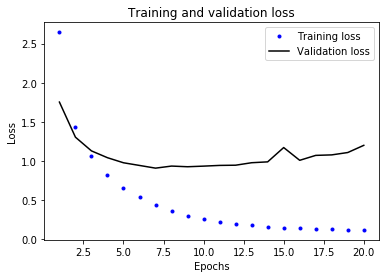

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'k', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

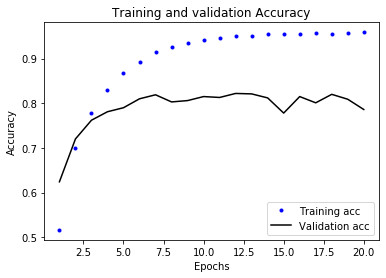

In [19]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.plot(epochs, val_acc, 'k', label='Validation acc')

plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We see that the network begins to overfit after nine epochs.

### Retraining from scratch

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 26ms/step - loss: 3.0341 - accuracy: 0.3914 - val_loss: 1.7134 - val_accuracy: 0.6360
Epoch 2/9
16/16 [==============================] - 0s 19ms/step - loss: 1.4798 - accuracy: 0.6962 - val_loss: 1.2994 - val_accuracy: 0.7110
Epoch 3/9
16/16 [==============================] - 0s 19ms/step - loss: 1.0838 - accuracy: 0.7708 - val_loss: 1.1444 - val_accuracy: 0.7610
Epoch 4/9
16/16 [==============================] - 0s 19ms/step - loss: 0.8454 - accuracy: 0.8193 - val_loss: 1.0391 - val_accuracy: 0.7830
Epoch 5/9
16/16 [==============================] - 0s 21ms/step - loss: 0.6747 - accuracy: 0.8607 - val_loss: 0.9653 - val_accuracy: 0.7980
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5299 - accuracy: 0.8931 - val_loss: 0.9480 - val_accuracy: 0.7980
Epoch 7/9
16/16 [==============================] - 0s 20ms/step - loss: 0.4376 - accuracy: 0.9127 - val_loss: 0.8996 - val_accuracy: 0.8180
Epoch 8/9
16/16 [===

In [21]:
results

[0.9679708480834961, 0.7885128855705261]

The accuracy of this network is almost 80%. This is significant, considering that selecting a classifier at random would to about 19% accuracy.  
We can demonstrate this below.

In [22]:
import copy

test_labels_copy = copy.copy(test_labels)

np.random.shuffle(test_labels_copy)

hits_array = np.array(test_labels) == np.array(test_labels_copy)

float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

## Predictions
Let's generate topic predictons for all of the test data.

In [23]:
predictions = model.predict(x_test)

Each entry in the resulting vector is of length 46

In [24]:
predictions[0].shape

(46,)

In [25]:
np.sum(predictions[0])

1.0000001

In [26]:
np.argmax(predictions[0]) # This will display the value with the highest probability

3

## Another way to handle labels and loss
In the previous example, it was mentioned that another wayt to ecode the labels would be to cast them as an integer tensor. We can do this as follows.

In [27]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used above, `categorical_corssentropy`, expects the labels to follow a categorical encoding. Fortunately they already do in this dataset, as each integer represents some category.

With integer labels, you should compile your model using `sparse_categorical_crossentropy` for the loss function:

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## The importance of having sufficiently large intermediate layers
We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 hidden units. Let's see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

In [29]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 3.6349 - accuracy: 0.0278 - val_loss: 3.1720 - val_accuracy: 0.1990
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 2.9468 - accuracy: 0.2583 - val_loss: 2.4741 - val_accuracy: 0.3030
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.1618 - accuracy: 0.3360 - val_loss: 1.7666 - val_accuracy: 0.6110
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4736 - accuracy: 0.6439 - val_loss: 1.4938 - val_accuracy: 0.6430
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1985 - accuracy: 0.6855 - val_loss: 1.4584 - val_accuracy: 0.6640
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1245 - accuracy: 0.7090 - val_loss: 1.4823 - val_accuracy: 0.6730
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0361 - accuracy: 0.7288 - val_loss: 1.4455 - val_accuracy: 0.6680
Epoch 8/20
63/63 [==

Accuracy has now dropped to about 65% from 79% in our model with 64-64-46 hidden units.

This drop is mostly due to the fact that you're trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. **The network is able to cram *most* of the necessary information into these four-dimensional representations, but not all of it.**

Generally, you won't use more than 2 hidden layers. The input layer should have one hidden unit for each feature of the data, and the hidden layer should have the mean between the input layer and the output layer. This should give a good compromise between overfitting and compression for most cases. Let's do that now, and start by looking at the dimensionality of the input vectors.

In [30]:
len(train_data[10])

31

In [31]:
model = models.Sequential()
model.add(layers.Dense(31, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(39, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=12,
    batch_size=128,
    validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/12
63/63 [==============================] - 1s 8ms/step - loss: 2.7178 - accuracy: 0.4980 - val_loss: 1.4673 - val_accuracy: 0.6720
Epoch 2/12
63/63 [==============================] - 0s 6ms/step - loss: 1.3032 - accuracy: 0.7153 - val_loss: 1.2199 - val_accuracy: 0.7200
Epoch 3/12
63/63 [==============================] - 0s 6ms/step - loss: 0.9880 - accuracy: 0.7803 - val_loss: 1.0739 - val_accuracy: 0.7620
Epoch 4/12
63/63 [==============================] - 0s 6ms/step - loss: 0.7359 - accuracy: 0.8417 - val_loss: 0.9732 - val_accuracy: 0.7890
Epoch 5/12
63/63 [==============================] - 0s 5ms/step - loss: 0.5548 - accuracy: 0.8794 - val_loss: 0.9306 - val_accuracy: 0.8000
Epoch 6/12
63/63 [==============================] - 0s 5ms/step - loss: 0.4344 - accuracy: 0.9109 - val_loss: 0.9198 - val_accuracy: 0.8080
Epoch 7/12
63/63 [==============================] - 0s 5ms/step - loss: 0.3502 - accuracy: 0.9195 - val_loss: 0.9585 - val_accuracy: 0.8030
Epoch 8/12
63/63 [==

The resulting accuracy drop is only about 1%, which is much better than the network with hidden units 64-4-46, but it should be noted that there is still a drop from the network 64-64-46. This is because the output is of higher dimension than the number of features in this particular dataset. So it may be better in these situations to construct neural networks where the intermediate layers are of the same dimension as the output, for example 46-46-46:

In [32]:
model = models.Sequential()
model.add(layers.Dense(46, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=12,
    batch_size=128,
    validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/12
63/63 [==============================] - 1s 8ms/step - loss: 2.6941 - accuracy: 0.4388 - val_loss: 1.3665 - val_accuracy: 0.6970
Epoch 2/12
63/63 [==============================] - 0s 6ms/step - loss: 1.1565 - accuracy: 0.7422 - val_loss: 1.0778 - val_accuracy: 0.7680
Epoch 3/12
63/63 [==============================] - 0s 6ms/step - loss: 0.8197 - accuracy: 0.8215 - val_loss: 0.9774 - val_accuracy: 0.7940
Epoch 4/12
63/63 [==============================] - 0s 6ms/step - loss: 0.5681 - accuracy: 0.8760 - val_loss: 0.9255 - val_accuracy: 0.8000
Epoch 5/12
63/63 [==============================] - 0s 6ms/step - loss: 0.4098 - accuracy: 0.9093 - val_loss: 0.9126 - val_accuracy: 0.8090
Epoch 6/12
63/63 [==============================] - 0s 6ms/step - loss: 0.3186 - accuracy: 0.9300 - val_loss: 0.9270 - val_accuracy: 0.8000
Epoch 7/12
63/63 [==============================] - 0s 6ms/step - loss: 0.2293 - accuracy: 0.9479 - val_loss: 0.9362 - val_accuracy: 0.8060
Epoch 8/12
63/63 [==